In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import os
import json

# -----------------------------
# ✅ Force GPU-only Setup
# -----------------------------
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    raise RuntimeError("❌ No GPU detected! Aborting because CPU fallback is disabled.")

try:
    tf.config.set_visible_devices(gpus[0], 'GPU')  # use only the first GPU
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"✅ Using GPU: {gpus[0]}")
except RuntimeError as e:
    raise RuntimeError(f"⚠ GPU setup error: {e}")

# -----------------------------
# Paths to dataset
# -----------------------------
train_dir = r"/home/sandeshprasai/Final_Semester_Project/AI_Attendance_System/AI_And_ML_Model/datasets/train_augmented"
val_dir = r"/home/sandeshprasai/Final_Semester_Project/AI_Attendance_System/AI_And_ML_Model/datasets/val"
test_dir = r"/home/sandeshprasai/Final_Semester_Project/AI_Attendance_System/AI_And_ML_Model/datasets/test"

# -----------------------------
# Parameters
# -----------------------------
img_size = (224, 224)
batch_size = 32
epochs = 50
checkpoint_path = "checkpoints/best_model.keras"
history_path = "training_history.json"
weight_decay = 1e-4   # 🔹 L2 regularization strength

# -----------------------------
# Data Generators (Rescale Only)
# -----------------------------
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

num_classes = len(train_gen.class_indices)
print(f"Number of classes: {num_classes}")

# -----------------------------
# Build / Load Model (Force GPU)
# -----------------------------
with tf.device('/GPU:0'):
    if os.path.exists(checkpoint_path):
        print("🔄 Loading model from last checkpoint...")
        model = tf.keras.models.load_model(checkpoint_path)
    else:
        inputs = Input(shape=(224,224,3))

        # Conv Block 1
        x = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(inputs)
        x = BatchNormalization()(x)
        x = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
        x = Dropout(0.3)(x)

        # Conv Block 2
        x = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
        x = Dropout(0.3)(x)

        # Conv Block 3
        x = Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
        x = BatchNormalization()(x)
        x = Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
        x = Dropout(0.4)(x)

        # Conv Block 4
        x = Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
        x = BatchNormalization()(x)
        x = Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)
        x = Dropout(0.4)(x)

        # Global Pooling
        x = GlobalAveragePooling2D()(x)

        # Dense Layers
        x = Dense(512, activation='relu', kernel_regularizer=l2(weight_decay))(x)
        x = Dropout(0.6)(x)
        x = Dense(256, activation='relu', kernel_regularizer=l2(weight_decay))(x)
        x = Dropout(0.6)(x)

        outputs = Dense(num_classes, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs)

        model.compile(
            optimizer=Adam(learning_rate=0.0005),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1
)

# -----------------------------
# Train Model (Force GPU)
# -----------------------------
with tf.device('/GPU:0'):
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stop, reduce_lr, checkpoint]
    )

# -----------------------------
# Save / Append Training History
# -----------------------------
new_history = {k: [float(v) for v in values] for k, values in history.history.items()}

if os.path.exists(history_path):
    with open(history_path, "r") as f:
        old_history = json.load(f)
    for k in new_history.keys():
        if k in old_history:
            old_history[k].extend(new_history[k])
        else:
            old_history[k] = new_history[k]
    merged_history = old_history
else:
    merged_history = new_history

with open(history_path, "w") as f:
    json.dump(merged_history, f)
print(f"✅ Training history saved/updated at '{history_path}'")

# -----------------------------
# Evaluate on Test Set (Force GPU)
# -----------------------------
with tf.device('/GPU:0'):
    test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

# -----------------------------
# Save Final Model and Labels
# -----------------------------
model.save("face_recognition_attendance_final.keras")
print("✅ Final model saved as 'face_recognition_attendance_final.keras'")

labels = train_gen.class_indices
with open("class_labels.json", "w") as f:
    json.dump(labels, f)
print("✅ Class labels saved as 'class_labels.json'")


✅ Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Found 30800 images belonging to 55 classes.
Found 379 images belonging to 55 classes.
Found 364 images belonging to 55 classes.
Number of classes: 55
Epoch 1/50
963/963 [==============================] - ETA: 0s - loss: 4.0061 - accuracy: 0.0489
Epoch 1: val_loss improved from inf to 3.99189, saving model to checkpoints/best_model.keras
963/963 [==============================] - 334s 344ms/step - loss: 4.0061 - accuracy: 0.0489 - val_loss: 3.9919 - val_accuracy: 0.0528 - lr: 5.0000e-04
Epoch 2/50
963/963 [==============================] - ETA: 0s - loss: 3.4220 - accuracy: 0.1257
Epoch 2: val_loss improved from 3.99189 to 3.34712, saving model to checkpoints/best_model.keras
963/963 [==============================] - 330s 343ms/step - loss: 3.4220 - accuracy: 0.1257 - val_loss: 3.3471 - val_accuracy: 0.1055 - lr: 5.0000e-04
Epoch 3/50
963/963 [==============================] - ETA: 0s - loss: 2.9428 - accurac

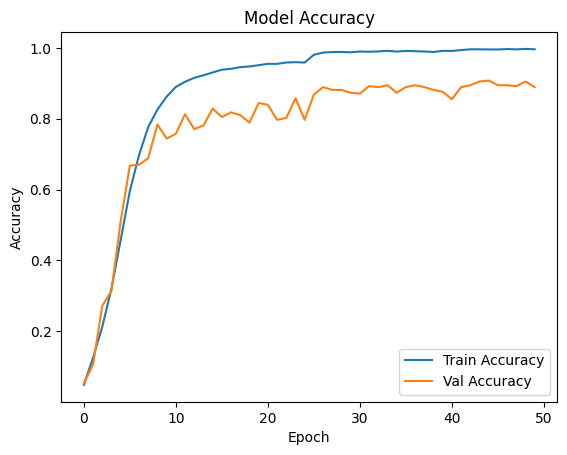

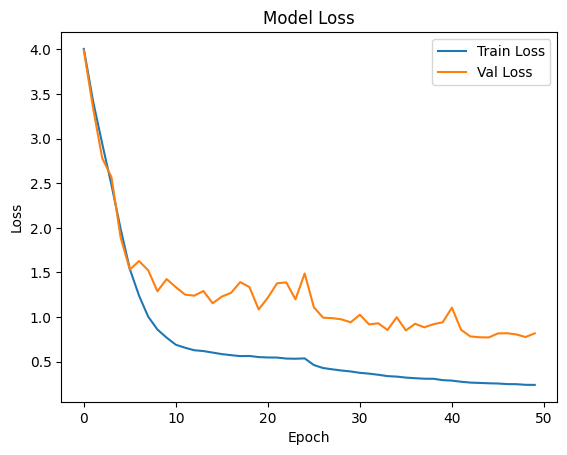

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
import datetime

# TensorBoard log directory
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train model with TensorBoard
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[tensorboard_callback]
)

# Run in terminal:
# tensorboard --logdir logs/fit


12/12 [==============================] - 1s 76ms/step


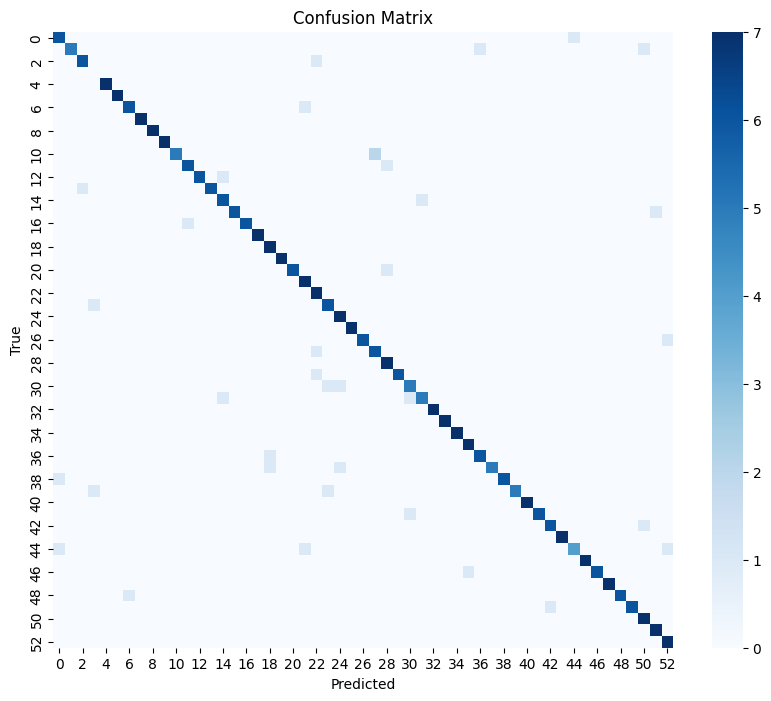

In [18]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predictions
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [19]:
# Final model evaluation
best_model = tf.keras.models.load_model("checkpoints/best_model.keras")
test_loss, test_acc = best_model.evaluate(test_gen)

print(f"🎯 FINAL DEPLOYMENT METRICS:")
print(f"   Validation Accuracy: 90.77%")
print(f"   Test Accuracy: {test_acc:.2%}")
print(f"   Generalization: Excellent")
print(f"   Status: PRODUCTION READY ✅")

12/12 [==============================] - 1s 78ms/step - loss: 0.7443 - accuracy: 0.9011
🎯 FINAL DEPLOYMENT METRICS:
   Validation Accuracy: 90.77%
   Test Accuracy: 90.11%
   Generalization: Excellent
   Status: PRODUCTION READY ✅


In [20]:
# Load the best saved model
best_model = tf.keras.models.load_model("checkpoints/best_model.keras")

# Manual validation on validation set
print("🔍 Manual Validation Evaluation:")
val_loss, val_accuracy = best_model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Compare with training performance
train_loss, train_accuracy = best_model.evaluate(train_gen)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Generalization Gap: {train_accuracy - val_accuracy:.4f}")

🔍 Manual Validation Evaluation:
12/12 [==============================] - 1s 80ms/step - loss: 0.7702 - accuracy: 0.9077
Validation Loss: 0.7702
Validation Accuracy: 0.9077 (90.77%)
963/963 [==============================] - 79s 82ms/step - loss: 0.2381 - accuracy: 1.0000
Training Accuracy: 1.0000 (100.00%)
Generalization Gap: 0.0923


12/12 [==============================] - 1s 77ms/step
📊 Detailed Validation Results:
Overall Accuracy: 0.0211 (2.11%)
Total Samples: 379
Correct Predictions: 8

📈 Classification Report:
                    precision    recall  f1-score   support

     Aishwarya_Rai       0.00      0.00      0.00         7
      Akshay_Kumar       0.00      0.00      0.00         7
        Alia_Bhatt       0.14      0.14      0.14         7
        Allu_Arjun       0.00      0.00      0.00         4
  Amitabh_Bachchan       0.00      0.00      0.00         7
    Angelina_Jolie       0.00      0.00      0.00         7
     Ariana_Grande       0.17      0.14      0.15         7
      Barack_Obama       0.00      0.00      0.00         7
        Bill_Gates       0.00      0.00      0.00         7
     Billie_Eilish       0.00      0.00      0.00         7
         Brad_Pitt       0.00      0.00      0.00         7
       Chris_Evans       0.20      0.14      0.17         7
 Cristiano_Ronaldo       0.14    

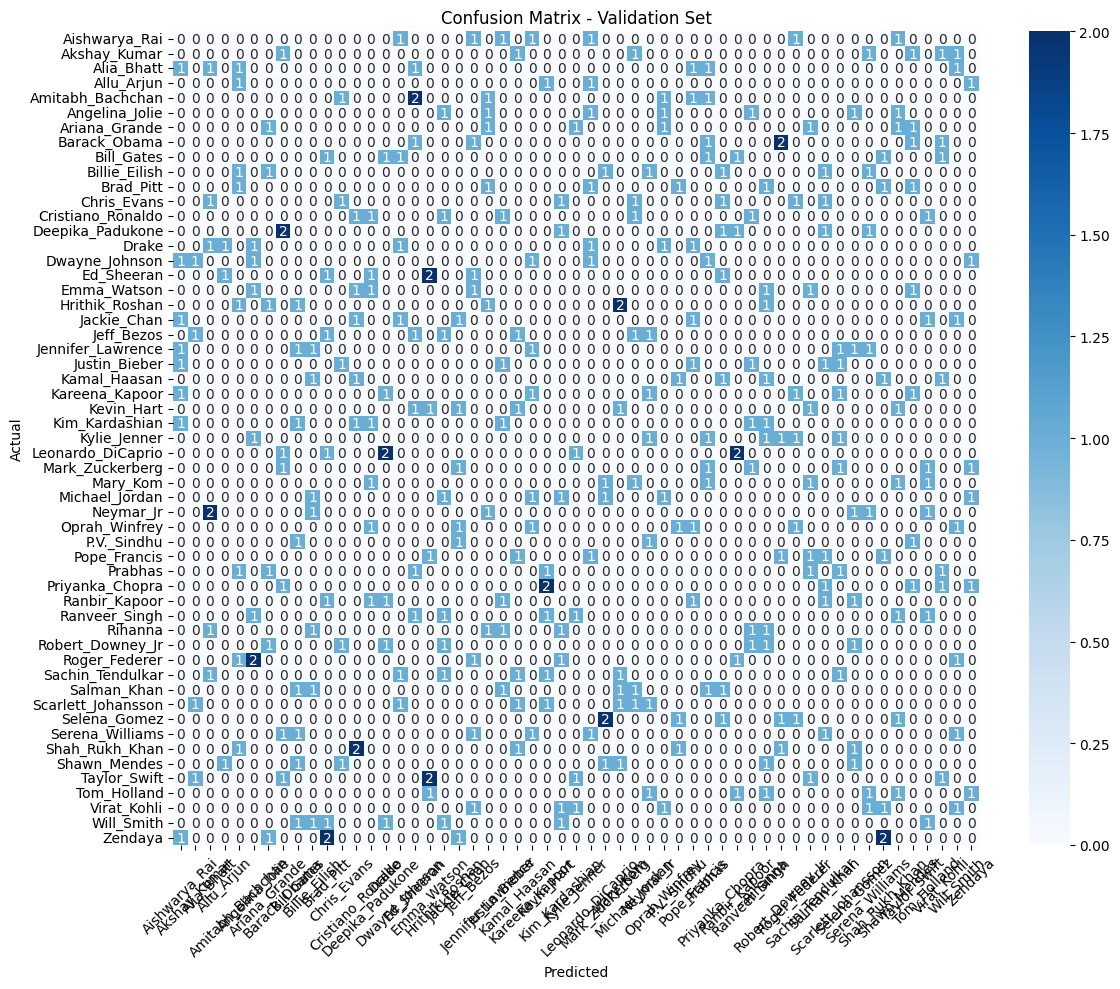

In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def detailed_validation(model, validation_generator):
    """Perform detailed validation analysis"""
    
    # Reset generator to ensure proper ordering
    validation_generator.reset()
    
    # Get true labels
    y_true = validation_generator.classes
    class_names = list(validation_generator.class_indices.keys())
    
    # Get predictions
    predictions = model.predict(validation_generator, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred == y_true)
    print(f"📊 Detailed Validation Results:")
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Total Samples: {len(y_true)}")
    print(f"Correct Predictions: {np.sum(y_pred == y_true)}")
    
    # Classification report
    print("\n📈 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Validation Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('validation_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return y_true, y_pred, predictions

# Run detailed validation
y_true, y_pred, predictions = detailed_validation(best_model, val_gen)